## kosarak

EOF
Top-1024,Sketch:8*2688
Execution time:  15.640 seconds.
Precision:  0.709
Top_dict with 36968 bytes.
Sketch with 86128 bytes.
Sk_head with 1528 bytes.
Total size 124624 bytes, 
Find:726
Top_ARE: 0.0590
Top_AAE: 3.4876
Estimate time:  0.881 seconds.


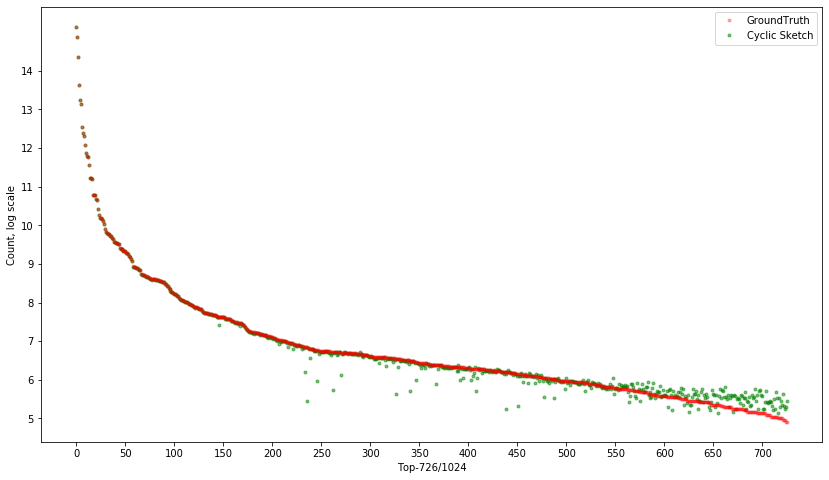

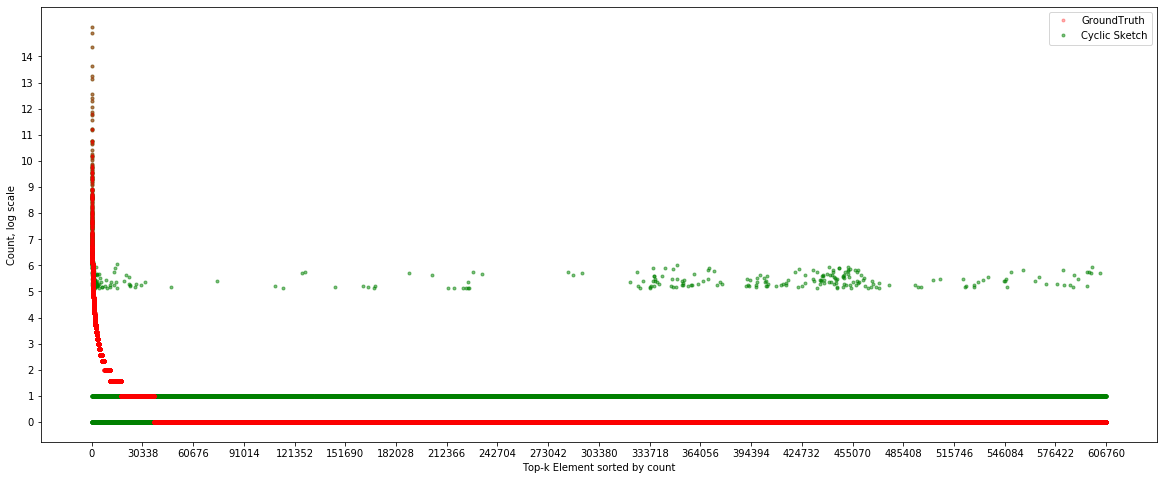

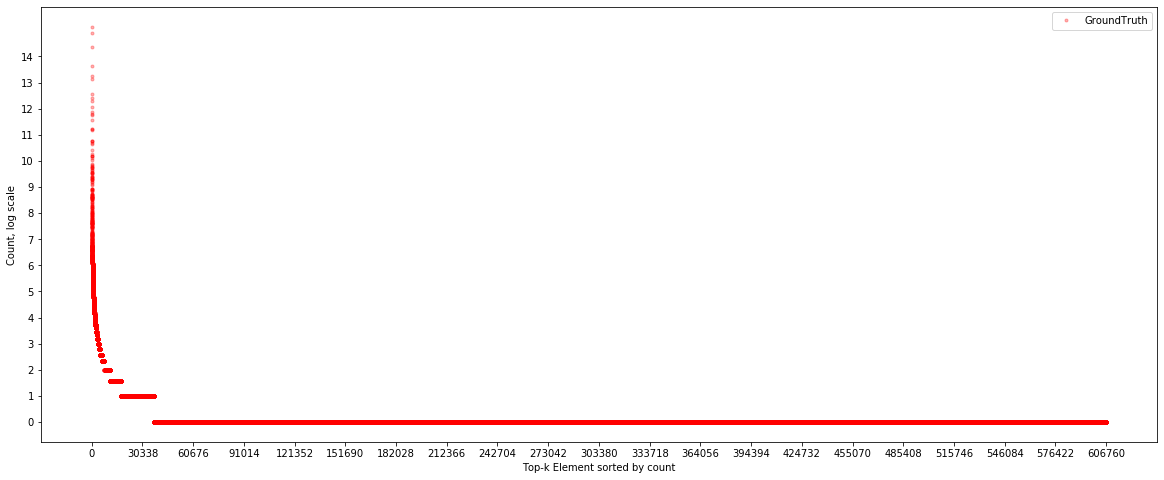

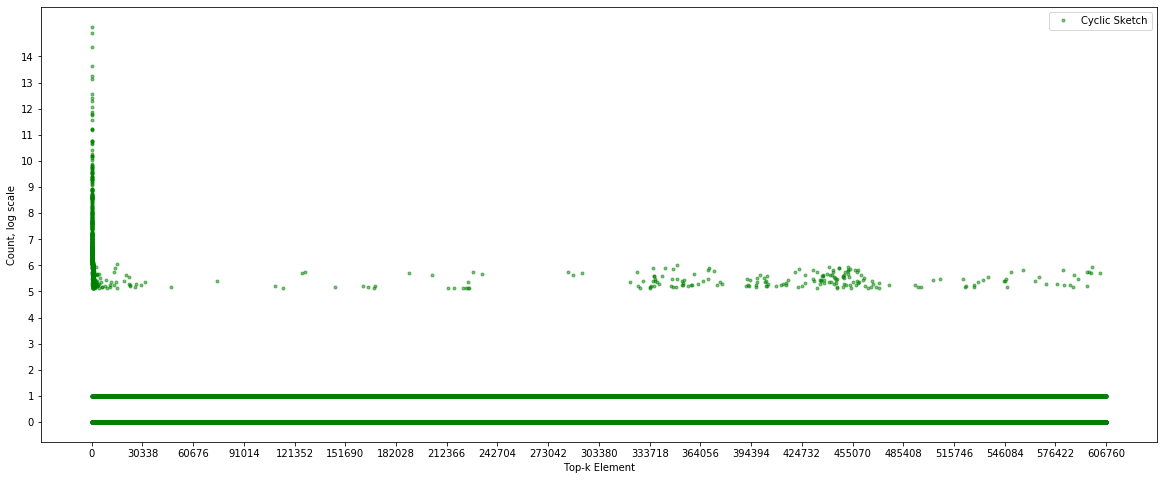

In [3]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np

import time
import os

'''
TF.tracemalloc.start()
    # start track memory usage===========================================================
'''

    
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth
    
w=2688
d=8
size=1024
topk=1024
TC.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    # Config.width, Config.depth
Sk_head=[DS.Head(0) for j in range(TC.depth)]
Sketch=np.zeros((TC.depth,TC.width),dtype='int32')
Top_dict=dict()
e_min=DS.Tail("",1)

start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            item=DS.Tail(e,1)
            if Top_dict.get(item.ID):
                # e in Top
                Top_dict[item.ID]+=1
            else:
                if len(Top_dict)<TC.size:
                    Top_dict[item.ID]=1
                else:
                    TF.UpdateSk(item,Sk_head,Sketch)
        if TC.e_max.count>e_min.count:
            min_ele = min(Top_dict, key=Top_dict.get)
                # 找dict中的最小key元素
            e_min=DS.Tail(min_ele,Top_dict[min_ele])
            TF.BringBack(e_min,Top_dict,Sk_head,Sketch)
end=time.time()

'''
snapshot = TF.tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
    # stop track memory usage===========================================================
'''

print("Top-{},Sketch:{}*{}".format(TC.size,TC.depth,TC.width))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Element-Precision
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
tp_set,precision=TF.Get_precision(gr_path,Top_dict,TC.topk)
    # send default top k
print("Precision: {:6.3f}".format(precision))


'''
# display memory usage
TF.display_top(snapshot)
'''
print("Top_dict with {} bytes.".format(sys.getsizeof(Top_dict)))
print("Sketch with {} bytes.".format(sys.getsizeof(Sketch)))
sk1=sys.getsizeof(Sk_head[0].distinct.__slots__)
sk2=sys.getsizeof(Sk_head[0].count)
sk3=sys.getsizeof(Sk_head[0].maxID)
sk4=sys.getsizeof(Sk_head[0].keep)
sk_sum=sum([sk1,sk2,sk3,sk4])*TC.depth
print("Sk_head with {} bytes.".format(sk_sum))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(Sketch)+sk_sum))

# Count ARE/AAE in Top
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,Top_dict,tp_set)
print("Find:{}".format(len(tp_set)))
#print("{} item found in SS[{}] compare with true Top-{}".format(len(tp_set),Config.size,topk))
endx=time.time()

print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
TF.Plot_topk_compare(gr_path,Top_dict,"Cyclic Sketch")

# All element compare
cardinality=[len(i.distinct) for i in Sk_head]
    # list for all row cardinality
ground_truth=TF.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    My_result[item]=TF.Query8(item,Top_dict,Sk_head,Sketch,cardinality)

TF.Plot_all_compare(ground_truth,My_result,"Cyclic Sketch")

In [ ]:
print(sum(Top_dict.values()))
print(Top_dict)

In [ ]:
print(Sk_head)
cardinality=[len(i.distinct) for i in Sk_head]
    # list for all row cardinality
for item in Sk_head:
    print(TF.Query8(item.maxID,Top_dict,Sk_head,Sketch,cardinality))

In [ ]:
print(Sk_head)

In [ ]:
print(Sketch)

## Caida

EOF
Top-1024,Sketch:8*2688
Execution time:  34.042 seconds.
Precision:  0.877
Top_dict with 36968 bytes.
Sketch with 86128 bytes.
Sk_head with 1848 bytes.
Total size 124944 bytes, 
Find:898
Top_ARE: 0.0411
Top_AAE: 24.7851
Estimate time:  0.210 seconds.


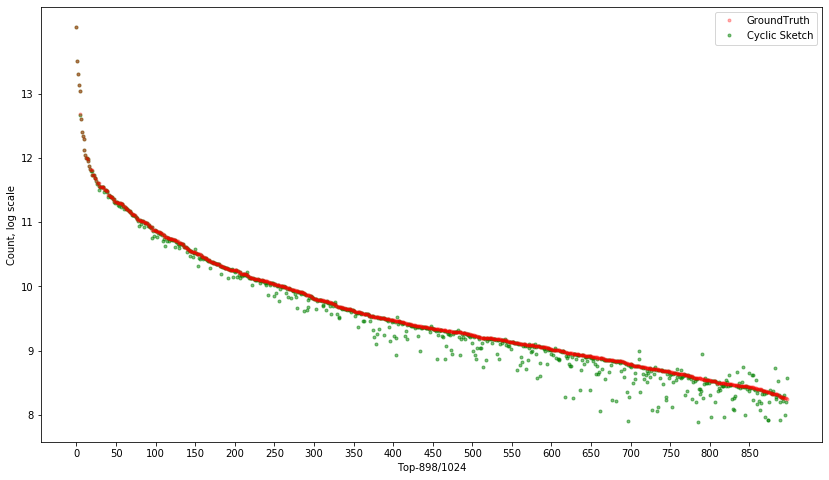

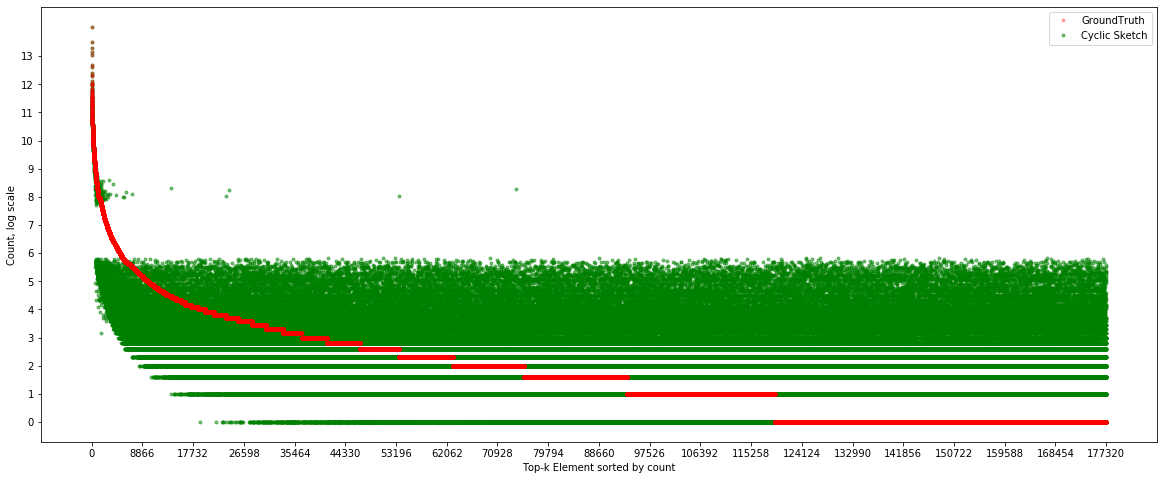

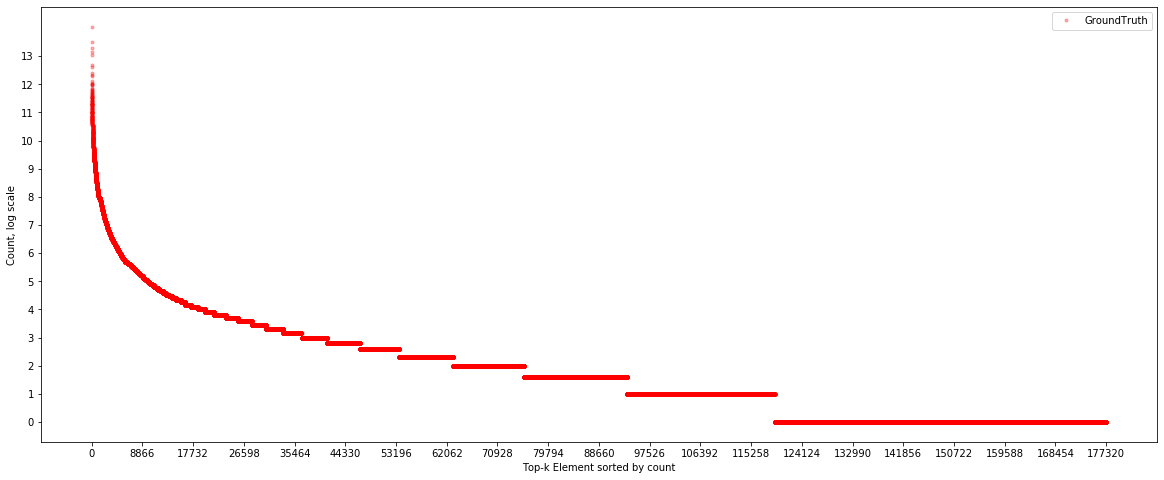

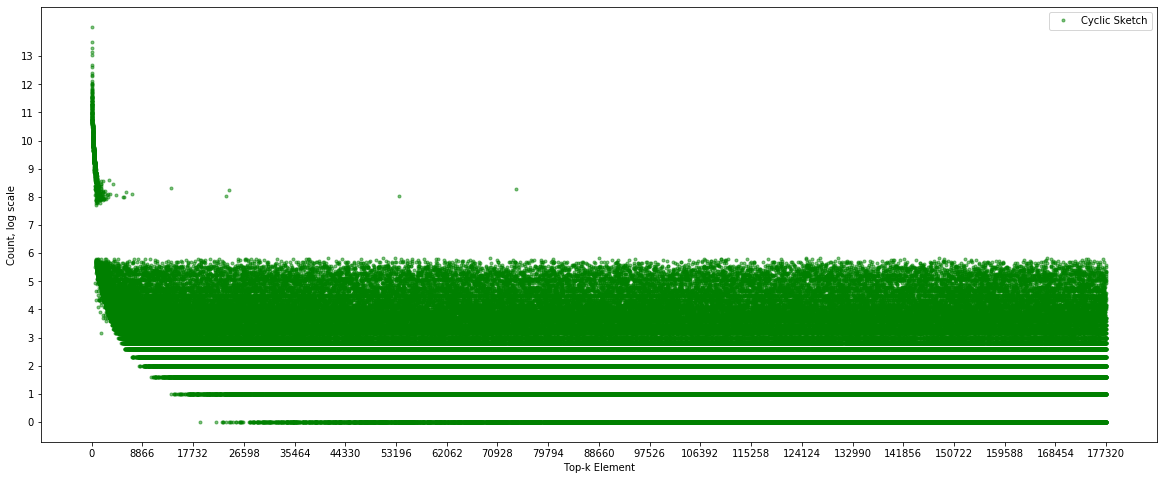

In [4]:
# 20210901 rewrite

import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import re

'''
TF.tracemalloc.start()
    # start track memory usage===========================================================
'''

# set dataset and ground truth file path    
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='caida_0_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# Top and Sketch parameter config
w=2688
d=8
size=1024
topk=1024
TC.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    
# Initialize Top, Sketch and Sk_head
Sk_head=[DS.Head(0) for j in range(TC.depth)]
Sketch=np.zeros((TC.depth,TC.width),dtype='int32')
Top_dict=dict()
e_min=DS.Tail("",1)

# Stream processing
start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=str(file.read(13))
            if len(e)<13:
                print('EOF')
                break
            else:
                #item_count-=1
                item=DS.Tail(e,1)
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]+=1
                else:
                    if len(Top_dict)<TC.size:
                        Top_dict[item.ID]=1
                    else:
                        TF.UpdateSk(item,Sk_head,Sketch)
            if TC.e_max.count>e_min.count:
                min_ele = min(Top_dict, key=Top_dict.get)
                    # 找dict中的最小key元素
                e_min=DS.Tail(min_ele,Top_dict[min_ele])
                TF.BringBack(e_min,Top_dict,Sk_head,Sketch)
end=time.time()

'''
snapshot = TF.tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
    # stop track memory usage===========================================================
'''


print("Top-{},Sketch:{}*{}".format(TC.size,TC.depth,TC.width))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Element-Precision
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
tp_set,precision=TF.Get_precision(gr_path,Top_dict,TC.topk)
    # send default top k
print("Precision: {:6.3f}".format(precision))

'''
# display memory usage
TF.display_top(snapshot)
'''

print("Top_dict with {} bytes.".format(sys.getsizeof(Top_dict)))
print("Sketch with {} bytes.".format(sys.getsizeof(Sketch)))
sk1=sys.getsizeof(Sk_head[0].distinct.__slots__)
sk2=sys.getsizeof(Sk_head[0].count)
sk3=sys.getsizeof(Sk_head[0].maxID)
sk4=sys.getsizeof(Sk_head[0].keep)
sk_sum=sum([sk1,sk2,sk3,sk4])*TC.depth
print("Sk_head with {} bytes.".format(sk_sum))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(Sketch)+sk_sum))

# Count ARE/AAE in Top
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,Top_dict,tp_set)
print("Find:{}".format(len(tp_set)))
#print("{} item found in SS[{}] compare with true Top-{}".format(len(tp_set),Config.size,topk))
endx=time.time()

print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
TF.Plot_topk_compare(gr_path,Top_dict,"Cyclic Sketch")

# All element compare
cardinality=[len(i.distinct) for i in Sk_head]
    # list for all row cardinality
ground_truth=TF.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    My_result[item]=TF.Query8(item,Top_dict,Sk_head,Sketch,cardinality)

TF.Plot_all_compare(ground_truth,My_result,"Cyclic Sketch")

## webdocs

EOF
Top-1024,Sketch:8*2688
Execution time: 161.269 seconds.
Precision:  0.938
Top_dict with 36968 bytes.
Sketch with 86128 bytes.
Sk_head with 1504 bytes.
Total size 124600 bytes, 
Find:960
Top_ARE: 0.0053
Top_AAE: 22.6135
Estimate time:  0.677 seconds.


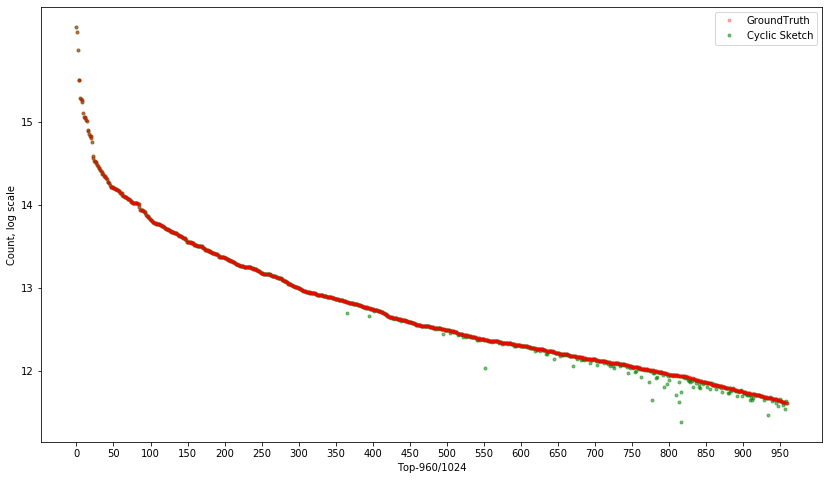

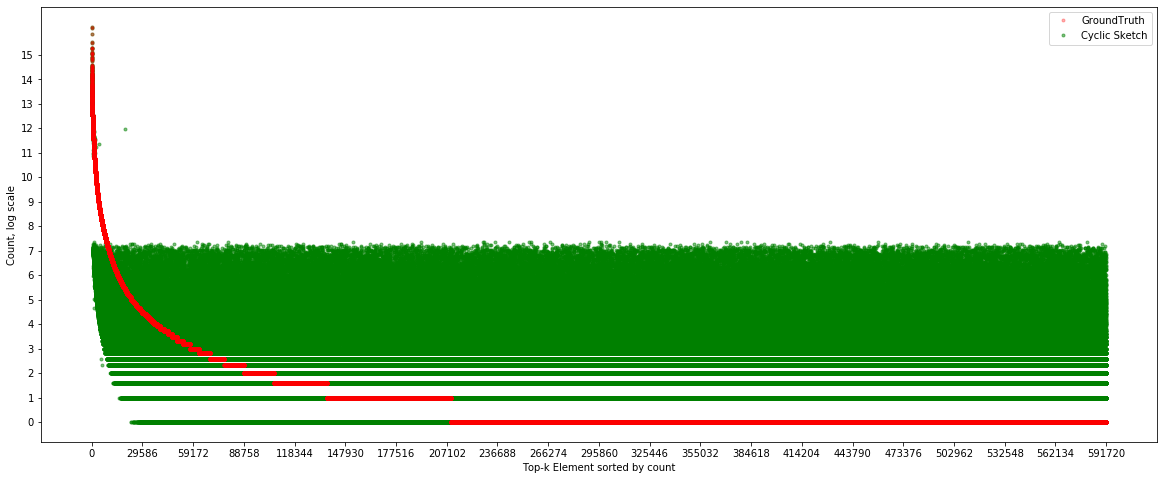

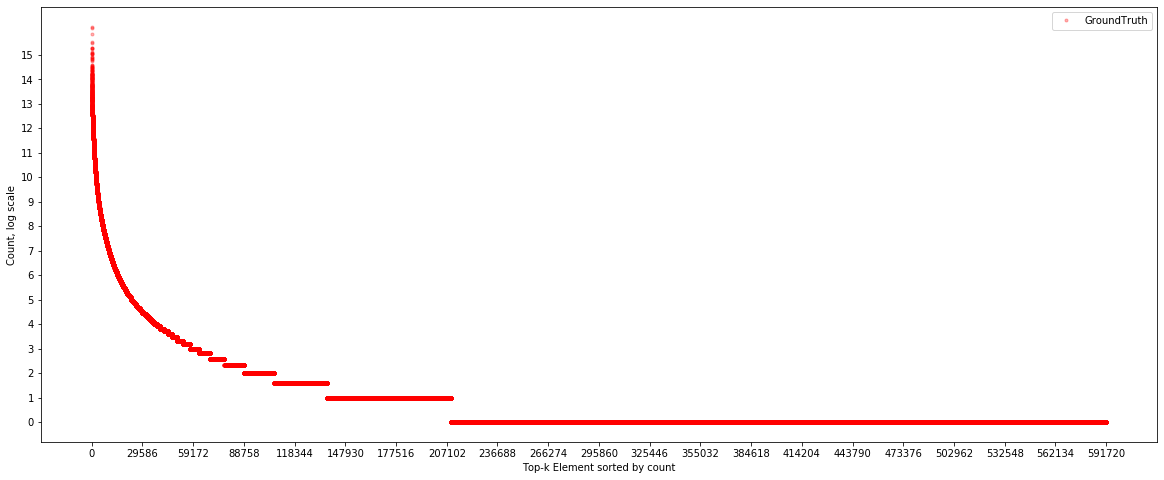

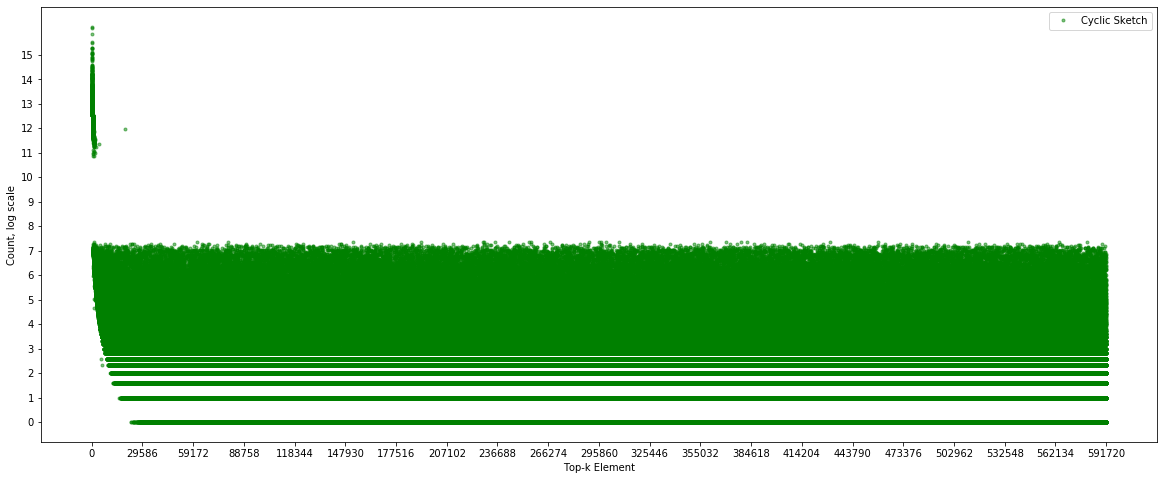

In [5]:
# 20210901 rewrite

import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import re

'''
TF.tracemalloc.start()
    # start track memory usage===========================================================
'''


# set dataset and ground truth file path
filepath=r"..\..\dataset\webdocs"
pattern='out_.*'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='webdocs_00_ground_truth.csv'        
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# Top and Sketch parameter config
w=2688
d=8
size=1024
topk=1024
TC.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    
# Initialize Top, Sketch and Sk_head
Sk_head=[DS.Head(0) for j in range(TC.depth)]
Sketch=np.zeros((TC.depth,TC.width),dtype='int32')
Top_dict=dict()
e_min=DS.Tail("",1)

start=time.time()
for datafile in filelist[:1]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'r') as file:
        while True:
            e=file.readline().strip('\n')
            if not e:
                print("EOF")
                break
            else:
                #item_count-=1
                item=DS.Tail(e,1)
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]+=1
                else:
                    if len(Top_dict)<TC.size:
                        Top_dict[item.ID]=1
                    else:
                        TF.UpdateSk(item,Sk_head,Sketch)
            if TC.e_max.count>e_min.count:
                min_ele = min(Top_dict, key=Top_dict.get)
                    # 找dict中的最小key元素
                e_min=DS.Tail(min_ele,Top_dict[min_ele])
                TF.BringBack(e_min,Top_dict,Sk_head,Sketch)
end=time.time()

'''
snapshot = TF.tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
    # stop track memory usage===========================================================
'''


print("Top-{},Sketch:{}*{}".format(TC.size,TC.depth,TC.width))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Element-Precision
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
tp_set,precision=TF.Get_precision(gr_path,Top_dict,TC.topk)
    # send default top k
print("Precision: {:6.3f}".format(precision))

'''
# display memory usage
TF.display_top(snapshot)
'''

print("Top_dict with {} bytes.".format(sys.getsizeof(Top_dict)))
print("Sketch with {} bytes.".format(sys.getsizeof(Sketch)))
sk1=sys.getsizeof(Sk_head[0].distinct.__slots__)
sk2=sys.getsizeof(Sk_head[0].count)
sk3=sys.getsizeof(Sk_head[0].maxID)
sk4=sys.getsizeof(Sk_head[0].keep)
sk_sum=sum([sk1,sk2,sk3,sk4])*TC.depth
print("Sk_head with {} bytes.".format(sk_sum))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(Sketch)+sk_sum))

# Count ARE/AAE in Top
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,Top_dict,tp_set)
print("Find:{}".format(len(tp_set)))
#print("{} item found in SS[{}] compare with true Top-{}".format(len(tp_set),Config.size,topk))
endx=time.time()

print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
TF.Plot_topk_compare(gr_path,Top_dict,"Cyclic Sketch")

# All element compare
cardinality=[len(i.distinct) for i in Sk_head]
    # list for all row cardinality
ground_truth=TF.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    My_result[item]=TF.Query8(item,Top_dict,Sk_head,Sketch,cardinality)

TF.Plot_all_compare(ground_truth,My_result,"Cyclic Sketch")                

In [ ]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np

import time
import os
import random
import string


stream_size=100
input_stream=[random.choice(string.ascii_lowercase) for _ in range(stream_size)]

ground_truth=dict()
item_count=0


w=8
d=4
size=5
topk=5
TC.Set_default(w,d,size,topk)
    # set width, depth, size of Sk, random seed of hash
    # Config.width, Config.depth
Sk_head=[DS.Head(0) for j in range(TC.depth)]
Sketch=np.zeros((TC.depth,TC.width),dtype='int32')
Top_dict=dict()
e_min=DS.Tail("",1)

start=time.time()
for e in input_stream:
    #item_count-=1
    print("{} arrives:".format(e))
    item=DS.Tail(e,1)
    if ground_truth.get(item.ID):
        ground_truth[item.ID]+=1
    else:
        ground_truth[item.ID]=1
    if Top_dict.get(item.ID):
        print("{} in Top".format(e))
        Top_dict[item.ID]+=1
    else:
        print("{} not in Top".format(e))
        if len(Top_dict)<TC.size:
            print("Top is not full:")
            Top_dict[item.ID]=1
        else:
            print("Top is full:")
            TF.UpdateSk(item,Sk_head,Sketch)
    if TC.e_max.count>e_min.count:
        print("Bring Back:")
        min_ele = min(Top_dict, key=Top_dict.get)
            # 找dict中的最小key元素
        e_min=DS.Tail(min_ele,Top_dict[min_ele])
        TF.BringBack(e_min,Top_dict,Sk_head,Sketch)
        
    print("Ground_truth: {}".format(ground_truth))
    print("Top: {}".format(Top_dict))
    print("Sk_head:{}".format(Sk_head))
    print("Sketch:\n{}".format(Sketch))
end=time.time()

'''
snapshot = TF.tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
    # stop track memory usage===========================================================
'''

print("Top-{},Sketch:{}*{}".format(TC.size,TC.depth,TC.width))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Element-Precision
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
tp_set,precision=TF.Get_precision(gr_path,Top_dict,TC.topk)
    # send default top k
print("Precision: {:6.3f}".format(precision))


'''
# display memory usage
TF.display_top(snapshot)
'''
print("Top_dict with {} bytes.".format(sys.getsizeof(Top_dict)))
print("Sketch with {} bytes.".format(sys.getsizeof(Sketch)))
sk1=sys.getsizeof(Sk_head[0].distinct.__slots__)
sk2=sys.getsizeof(Sk_head[0].count)
sk3=sys.getsizeof(Sk_head[0].maxID)
sk4=sys.getsizeof(Sk_head[0].keep)
sk_sum=sum([sk1,sk2,sk3,sk4])*TC.depth
print("Sk_head with {} bytes.".format(sk_sum))
print("Total size {} bytes, ".format(sys.getsizeof(Top_dict)+sys.getsizeof(Sketch)+sk_sum))

# Count ARE/AAE in Top
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,Top_dict,tp_set)
print("Find:{}".format(len(tp_set)))
#print("{} item found in SS[{}] compare with true Top-{}".format(len(tp_set),Config.size,topk))
endx=time.time()

print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
TF.Plot_topk_compare(gr_path,Top_dict,"Cyclic Sketch")

# All element compare
cardinality=[len(i.distinct) for i in Sk_head]
    # list for all row cardinality
ground_truth=TF.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    My_result[item]=TF.Query8(item,Top_dict,Sk_head,Sketch,cardinality)

TF.Plot_all_compare(ground_truth,My_result,"Cyclic Sketch")